# Importing Libraries 

In [1]:
import overpy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
from geopy.distance import great_circle
from shapely import geometry
from shapely.geometry import MultiPoint, Polygon
from matplotlib.collections import PathCollection
import smopy
import folium
import fiona
import geopandas as gpd
from shapely.ops import cascaded_union, polygonize
from geopy.geocoders import Nominatim

# Extracting Data

Getting point of interest (POI) data for DELHI in the box - 
    minimum latitude: 28.4844
    maximum latitude: 28.8188
    minimum longitude: 77.0231
    maximum longitude: 77.6617

Here, I have extracted all the nodes with the key shop, all the ways with the tag shop=mall.

In [2]:
api = overpy.Overpass()
r = api.query("""
(node['shop'](28.4844,77.0231,28.8188,77.6617);
 way['shop'='mall'](28.4844,77.0231,28.8188,77.6617);
);
out center;
""")

# Visualizing the raw data

In [3]:
map = smopy.Map((28.4844,77.0231,28.8188,77.6617), z=11)

Text(0.5, 1, 'Shops in Delhi')

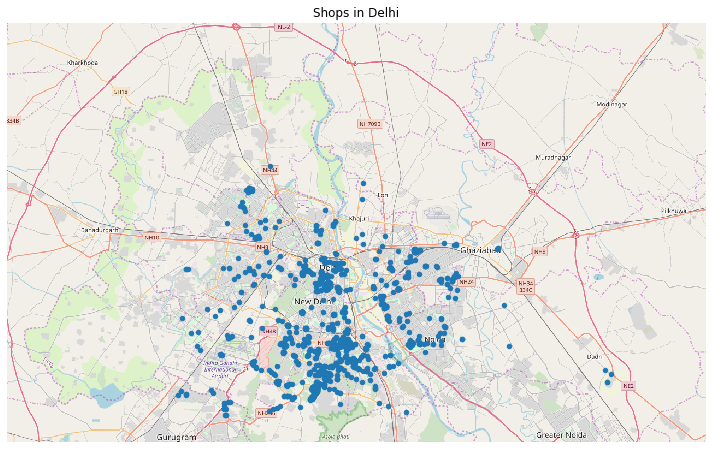

In [4]:
coords = []
for element in r.nodes:
    lon = element.lon
    lat = element.lat
    coords.append([float(lon), float(lat)])
X = np.array(coords)
x, y = map.to_pixels(X[:, 1],X[:, 0])
ax = map.show_mpl(figsize=(10, 10))
ax.scatter(x, y, s=20)
ax.set_title('Shops in Delhi')

# Clustering the node using DBSCAN

In [5]:
db = DBSCAN(eps=0.1/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [6]:
df = pd.DataFrame(coords,columns=['lon','lat'])
coords = df.as_matrix(columns=['lon','lat'])

C:\Users\sulay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [7]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print("No. of clusters formed are: " + str(num_clusters))

No. of clusters formed are: 43


In [8]:
clusters = pd.Series([coords[cluster_labels == n] for n in range(0,num_clusters)])
count = []
cluster_no = []
for i in range(num_clusters):
    count.append(len(clusters[i]))
    if(len(clusters[i])>10):
        cluster_no.append(i)
print("The clusters that include more than 10 nodes are: " + str(cluster_no))

The clusters that include more than 10 nodes are: [0, 3, 4, 7, 8, 9, 11, 14, 15, 23, 24, 29, 32, 33, 34, 37, 40]


If the cluster label is -1 then it means that it does not belong to any cluster. So we give it a color = 0 and the clustered nodes a color = 1

In [9]:
color = db.labels_
for i in range(len(color)):
    if color[i] == -1:
        color[i]=0
    else:
        color[i]=1
print(color)

[0 0 0 ... 1 1 0]


In [10]:
clusters = clusters[0:num_clusters-1]        #Getting all the clusters that are clustered

Getting the point which is closest to the centroid of the cluster. This will help in determining the nearest landmark of the cluster and thus help giving name to the cluster.

In [11]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [12]:
lons, lats = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
#rs = rep_points.apply(lambda row: df[(df['lat']==row['lat'])(df['lon']==row['lon'])].iloc[0], axis=1)

# Visualizing all the clusters by their centermost point

In [13]:
map = smopy.Map((28.4844,77.0231,28.8188,77.6617), z=11)

In [14]:
x, y = map.to_pixels(df['lat'],df['lon'])

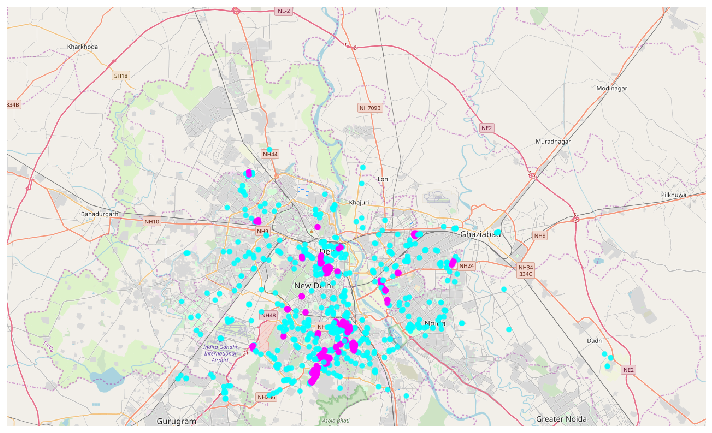

In [15]:
ax = map.show_mpl(figsize=(10, 10))
ax.scatter(x, y, c=color, alpha=0.9, s=20, cmap='cool')
#ax.plot(x,y,'or', ms=10, mew=2)

# Creating polygons for each cluster and way and giving labels to each cluster

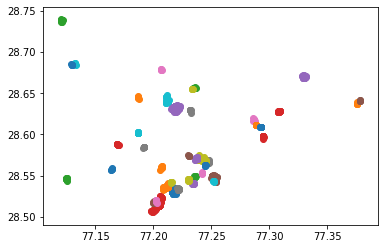

In [16]:
geo = []
name = []
geolocator = Nominatim(user_agent="specify_your_app_name_here")
for i in range(len(r.ways)):
    coords = []
    way = r.ways[i]
    nodes = way.get_nodes(resolve_missing=True)
    try:
        try:
            name.append(way.tags['name:en'])
        except:
            name.append(way.tags['name'])
    except:
        name.append('')
    for element in nodes:
        lon = element.lon
        lat = element.lat
        coords.append([float(lon), float(lat)])
    point_collection = geometry.MultiPoint(coords)

    convex_hull_polygon = point_collection.convex_hull
    geo.append(convex_hull_polygon)
    
for i in range(num_clusters-1):
    flag = 0
    lon_point_list = []
    lat_point_list = []
    for j in range(len(clusters[i])):
        lon_point_list.append(clusters[i][j][0])
        lat_point_list.append(clusters[i][j][1])
    plt.scatter(lon_point_list,lat_point_list)
    points=clusters[i]

    point_collection = geometry.MultiPoint(points)

    convex_hull_polygon = point_collection.convex_hull
    
    for j in range(len(geo)):
        if convex_hull_polygon.intersects(geo[j]):
            flag = 1
            break
    if flag==0:
        geo.append(convex_hull_polygon)
        if i in cluster_no:
            location = geolocator.reverse(str(rep_points['lat'][i]) + ',' + str(rep_points['lon'][i]))
            temp = location.address.split(', ')
            name.append(temp[1] + ' market')
        else:
            name.append('')

In [17]:
index = np.arange(0,len(geo))

In [18]:
dataframe = pd.DataFrame(name,columns=['name'])
dataframe['name']=dataframe['name'].astype(str)

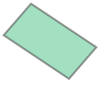

In [19]:
crs = {'init' :'epsg:4326'}
polygon = gpd.GeoDataFrame(dataframe, crs=crs, geometry=geo, columns=['name']) 
polygon.geometry[5]

# Saving the polygons as shapefile and geojson

In [20]:
polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

# Visualizing the graph through an interactive plot with popups

In [21]:
m = folium.Map([28.6496,77.238], zoom_start=10)
#folium.GeoJson('polygon.geojson',name='geojson').add_to(m)
folium.GeoJson('polygon.geojson',
               name='Commercial Markets and Centers',
               style_function=lambda x: {'weight':5,'color':'blue','dashArray':'1 3'},
               highlight_function=lambda x: {'weight':5,'color':'yellow', 'dashArray':'1 7'},
               tooltip=folium.features.GeoJsonTooltip(fields=['name']),
               smooth_factor=5.0,
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m